# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [ ]:
## The used car dealer is interested in determing what factors influence a used cars price.  Is the price related
## to horsepower, age, engine size?  Are there other identifiable characteristics that can be used

In [1]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from warnings import filterwarnings 
filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector


In [28]:
data = pd.read_csv('data/vehicles.csv')
data.info()
df=data.iloc[:5000]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [ ]:
## To better understand the data, I would start by looking at the columns and seeing what information
## I have to work with.  What are the data types, how many categorical items are there.

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [ ]:
## After looking at some of the data, I've noticed that I can exclude things like size, type, & VIN 
## when I am trying to calculate a sales price.  Also I've noticed that there are NULL values so initial
## step is to remove them.  We're left with ~125,000 entries. I then needed to make the categorical features
## workable and used pd.get_dummies to fill.  Additional examination later showed that the were entries with
## completely inaccurate prices and other data so it was dropped  

In [31]:
df = df.drop(['VIN','size','type'],axis=1)
df.dropna(inplace=True)
df.sort_values(by='price',ascending=False,inplace=True)
df_bad_price = df[df['price'] < 99999]
obj_cols = df.select_dtypes(include=['object']).columns

for col in obj_cols:
    df[col]=df[col].astype('category')

df_cleaned=pd.get_dummies(data=df_bad_price, columns = obj_cols)
y_log = np.log1p(df_cleaned['price'])
y = df_cleaned['price']
X = df_cleaned.drop(['price'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state = 42)

print(y.mean())

19039.667859699355


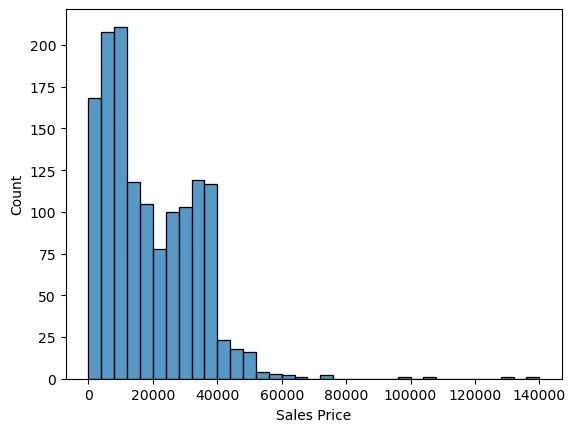

In [32]:
sns.histplot(df,x="price")
plt.xlabel("Sales Price")
plt.savefig('images/price_vs_count.png')

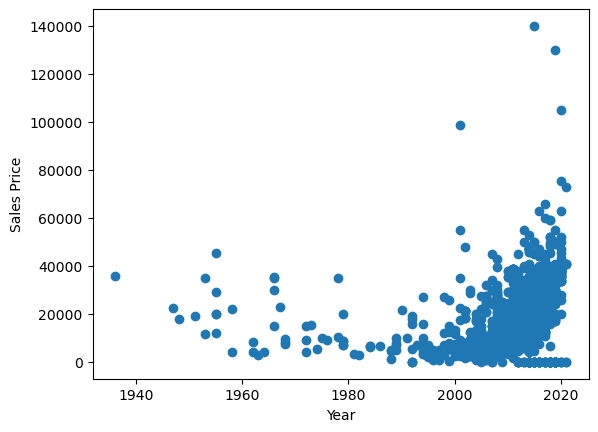

In [33]:
plt.scatter(df['year'],df['price'])
plt.xlabel("Year")
plt.ylabel("Sales Price")
plt.savefig('images/year_vs_price.png')

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [ ]:
## Started modelling with simple linear regression of odometer & price

In [7]:
X1 = X[['odometer']]
odo_linreg = LinearRegression(fit_intercept=False).fit(X1, y)
### END SOLUTION

# Answer check
print(odo_linreg)
print(type(odo_linreg))
odo_linreg.coef_

LinearRegression(fit_intercept=False)
<class 'sklearn.linear_model._base.LinearRegression'>


array([0.00108725])

In [ ]:
##adding in all features

In [8]:
all_linreg = LinearRegression(fit_intercept=False).fit(X, y)
linreg_mse = mean_squared_error(all_linreg.predict(X), y)

print(all_linreg)
print(type(all_linreg))
print(all_linreg.coef_)
print(linreg_mse)

LinearRegression(fit_intercept=False)
<class 'sklearn.linear_model._base.LinearRegression'>
[-3.84321205e-05  7.54485829e+02 -3.51621532e-05 -1.87094164e+05
 -3.88323282e+04 -3.80166520e+04 -3.84724453e+04 -3.89187146e+04
 -4.24500341e+04 -3.76105410e+04 -3.89011555e+04 -3.72272391e+04
 -3.90791722e+04 -1.29526245e+04 -2.18788990e+02 -1.69816285e+04
 -1.67089265e+04 -1.69486983e+04 -1.78822717e+04 -1.87707590e+04
 -1.98460977e+04 -2.20614935e+04  3.11668838e+04 -1.43528958e+04
 -1.84188577e+04 -2.28233918e+04 -1.78762631e+04 -1.69065534e+04
 -1.54749843e+04 -2.41441669e+04 -1.66315581e+04 -1.70301951e+04
 -1.92160470e+04 -1.00370095e+04 -1.84699016e+04 -1.60259725e+04
 -1.15558550e+04 -1.06653038e+04 -1.27351849e+04 -1.81360379e+04
 -1.54586430e+04 -7.21321792e+03 -1.71787308e+04 -1.21102151e+04
 -2.15654493e+04 -1.86162171e+04 -1.77144013e+04 -1.81644891e+04
 -1.69035120e+04 -7.28992680e+03 -8.33886438e+03 -7.04025727e+03
 -9.83324683e+03  1.89302396e+03  6.96925191e+03  7.27916480e+0

In [9]:
car_prediction = ''

### BEGIN SOLUTION
car_encoded = pd.get_dummies(X[['odometer', 'year', 'paint_color_black','fuel_diesel','condition_excellent']])

car_features = pd.DataFrame({
    'odometer': [10000],
    'year': [2019],
    'paint_color_black': [1],
    'fuel_diesel': [1],
    'condition_excellent': [1]
    
})

car_features_encoded = pd.get_dummies(car_features).reindex(columns=car_encoded.columns, fill_value=0)

car_linreg = LinearRegression(fit_intercept=False).fit(car_encoded, y)

car_prediction = car_linreg.predict(car_features_encoded)

car_prediction = round(car_prediction[0], 2)


print(car_prediction)
print(type(car_prediction))

19489.38
<class 'numpy.float64'>


In [ ]:
## Trying Ridge modeling

In [ ]:
ridge_models = []
ridge_scores = []

# List of different alpha values to try for Ridge Regression
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]

# Train a Ridge Regression model for each alpha and evaluate using cross-validation
for alpha in alphas:
    ridge = Ridge(alpha=alpha, random_state=0)
    ridge.fit(X_train, y_train)
    
    # Perform cross-validation and calculate RMSE
    scores = cross_val_score(ridge, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-scores)
    
    # Save the model and its cross-validation scores
    ridge_models.append(ridge)
    ridge_scores.append(rmse_scores)

# Display the RMSE scores for each alpha
ridge_scores

In [11]:
selector_pipe = Pipeline([('selector', SequentialFeatureSelector(LinearRegression())),
                         ('model', LinearRegression())])
param_dict = {}
selector_grid = ''
selector_train_mse = ''
selector_test_mse = ''

### BEGIN SOLUTION
param_dict = {'selector__n_features_to_select': [2, 3, 4, 5]}
selector_grid = GridSearchCV(selector_pipe, param_grid=param_dict)
selector_grid.fit(X_train, y_train)
train_preds = selector_grid.predict(X_train)
test_preds = selector_grid.predict(X_test)
selector_train_mse = mean_squared_error(y_train, train_preds)
selector_test_mse = mean_squared_error(y_test, test_preds)
### END SOLUTION

# ANSWER CHECK
print(f'Train MSE: {selector_train_mse}')
print(f'Test MSE: {selector_test_mse}')

Train MSE: 111207266.09599568
Test MSE: 82744345.12188263


In [12]:
ridge_param_dict = ''
ridge_pipe = ''
ridge_grid = ''
ridge_train_mse = ''
ridge_test_mse = ''

### BEGIN SOLUTION
ridge_param_dict = {'ridge__alpha': np.logspace(0, 10, 50)}
ridge_pipe = Pipeline([('scaler', StandardScaler()), 
                      ('ridge', Ridge())])
ridge_grid = GridSearchCV(ridge_pipe, param_grid=ridge_param_dict)
ridge_grid.fit(X_train, y_train)
ridge_train_preds = ridge_grid.predict(X_train)
ridge_test_preds = ridge_grid.predict(X_test)
ridge_train_mse = mean_squared_error(y_train, ridge_train_preds)
ridge_test_mse = mean_squared_error(y_test, ridge_test_preds)
### END SOLUTION

# ANSWER CHECK
print(f'Train MSE: {ridge_train_mse}')
print(f'Test MSE: {ridge_test_mse}')

Train MSE: 27899343.82153275
Test MSE: 61637646.314477086


In [13]:
best_estimator = ''
best_selector = ''
best_model = ''
feature_names = ''
coefs = ''


### BEGIN SOLUTION
best_estimator = selector_grid.best_estimator_
best_selector = best_estimator.named_steps['selector']
best_model = selector_grid.best_estimator_.named_steps['model']
feature_names = X_train.columns[best_selector.get_support()]
coefs = best_model.coef_
### END SOLUTION

# Answer check
print(best_estimator)
print(f'Features from best selector: {feature_names}.')
print('Coefficient values: ')
print('===================')
pd.DataFrame([coefs.T], columns = feature_names, index = ['model'])

Pipeline(steps=[('selector',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select=5)),
                ('model', LinearRegression())])
Features from best selector: Index(['year', 'odometer', 'model_super duty f-550 drw', 'transmission_other',
       'drive_fwd'],
      dtype='object').
Coefficient values: 


,year,odometer,model_super duty f-550 drw,transmission_other,drive_fwd
model,357.881648,-0.002515,23872.859646,13504.238829,-9231.402649


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [ ]:
## As I went through this exercise, there were several spots that forced me to go back and reconsider things.
## I didn't realize at first that there were prices that needed to be excluded - completely made up which would
## greatly skew the model.  Another thing I did was to select 5000 rows from the initial data set.  I tried
## working with the entire set, but due to it's size, it wasn't feasible to run through the various iterations.
## Ideally, I would use a computer with higher speed to process the larger set and run through these models with
## the entire set.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

In [ ]:
## I have developed two different model/approaches to used car inventory & prices.  The first model would allow 
## a dealer to input characteristics about a car and determine a typical sales price.  This can be used initially
## to negotiate a trade-in or purchase price to ensure the appropriate profit margin...enter several characteristics
## and the model will tell you the predicted sales price.  Depending on overhead, carrying costs, or required
## repairs, you can figure out if it's a good deal.  The second model determined what are the best features to 
## choose to maximize price.  This would also be used to target a kind of vehicle to add to the lot.  If you
## want to fill the lot with the highest priced vehicles, then low mileage, newer, FWD, and super duty F550 are
## what will drive a higher price.